# Homework 1

We start by importing the packages we will need. Notice that we fix the seed of the random number generator so everyone obtains the same results.

In [1]:
using JuMP
using Cbc
using Random
Random.seed!(2)         # Control random number generation
using LinearAlgebra
using Plots
using Statistics
using BenchmarkTools

We generate the instances at random, given a predefined number of potential suppliers ($i \in I$), demand points ($j \in J$) and time periods ($t \in T$), all parameters are randomly generated.

In [2]:
# This structure will ease the passing of the specific instance for the functions 
# that generate and solve the optimization model.
mutable struct Instance
    nI     # Number of suppliers      
    nJ     # Number of demand points
    nT     # Number of periods
    I      # Supplier range
    J      # Demand points range
    T      # Periods range
    C      # Unit capacity costs per supplier
    H      # Unit storage cost per supplier
    M      # Production cost per supplier
    D      # Client demands in all periods
    Q      # Unit costs of unfulfilled demand
    F      # Unit costs to fulfil demands 
end

In [3]:
## Problem data
nI = 25                                # Number of suppliers      
nJ = 25                                # Number of demand points
nT = 10                                # Number of periods
I_range = 1:nI                         # Supplier range
J = 1:nJ                               # Demand points range
T = 1:nT                               # Periods range

## Generate random data for the problem
C = rand(20:200, nI)                   # Unit capacity costs per supplier
H = rand(1:4, nI)                      # Unit storage cost per supplier
M = rand(10:40, nI)                    # Production cost per supplier
D = rand(nJ,nT).*rand(100:500, nJ)     # Client demands in all periods
Q = rand(5000:10000, nJ)               # Unit costs of unfulfilled demand
F = rand(3:45, (nI,nJ))                # Unit costs to fulfil demands

# This packages the problem instance information into a single structure.
ins = Instance(nI, nJ, nT, I_range, J, T, C, H, M, D, Q, F);

## Task 1.1

The function ```solve_deterministic()``` generates and solves the deterministic model. It is good practice to wrap procedures that might be potentially called multiple times in functions. We also consider a keyword argument (following the ;) to turn off any printing in the code.

You are required to complete this function by 
1. Adding the model variables
2. Adding the model objective
3. Adding the model constraints.

Notice that the object ```model``` has been already predefined.

In [4]:
# THIS CELL WILL BE AUTOGRADED
function solve_deterministic(ins::Instance; verbose = true)
    
    ## Renaming for making the implementation clearer
    I = ins.I
    J = ins.J
    T = ins.T 
    C = ins.C
    H = ins.H
    M = ins.M
    D = ins.D
    Q = ins.Q
    F = ins.F
    
    
    model = Model(Cbc.Optimizer)                        # We use Cbc solver

    ## Variables
    @variable(model, x[i in I] >= 0)                    # Capacity per supplier
    @variable(model, p[i in I, t in T] >= 0)            # Units produced per supplier per period
    @variable(model, k[i in I, t in T] >= 0)            # Units stored in each supplier and period
    @variable(model, e[i in I, j in J, t in T] >= 0)    # Units transported from supplier i to demand point j at period t
    @variable(model, u[j in J, t in T] >= 0)            # Unfulfilled demand per demand point and period

    ## Objective: Minimize the total costs
    @objective(model, Min,
          sum(C[i] * x[i] for i in I) +
          sum(H[i] * k[i,t] + M[i]*p[i,t] for t in T, i in I) +
          sum(F[i,j] * e[i,j,t] for t in T, i in I, j in J) + 
          sum(Q[j] * u[j,t] for t in T, j in J)
    )

    ## Constraints
    ## Capacity limit for each supplier i in each period t
    @constraint(model, Cap[i in I, t in T], p[i,t] <= x[i])

    ## Supply balance constraint
    ## (T=1): First period do not count with previous stocks
    # @constraint(model, SupBal1[i in I, t in [1]], p[i,t] == sum(e[i,j,t] for j in J) + k[i,t])
    ## (T>1): All periods but the first are balanced with the storage levels decided in the previous periods
    @constraint(model, SupBal2[i in I, t in T[T.>1]], p[i,t] + k[i,t-1] == sum(e[i,j,t] for j in J) + k[i,t])

    ## Demand balance constraint (u[j,s] is unfulfilled demand of client j at time t)
    @constraint(model, DemBal[j in J, t in T], sum(e[i,j,t] for i in I) == D[j,t] - u[j,t])

    if !verbose
        set_silent(model)                     # Omit solver log
    end
    optimize!(model)                    # Solve the problem
    status = termination_status(model)        # Solution status
    if verbose
        println("Model status = $(status)")   # Print status
    end
    
    return (x,p,k,e,u)
end;    

Once the function above is completed, we can now solve the deterministic model. We also included some code to extract the solution obtained from the model.

In [5]:
## Solve the deterministic model
(x_det,p_det,k_det,e_det,u_det) = solve_deterministic(ins, verbose = false)

xsol_det = value.(x_det)                          # Get optimal x values (reserved capacities)
xsol_det = round.(xsol_det.data, digits = 2)      # Round to 2 decimals 
fval_det = dot(C, xsol_det)                       # Optimal cost of reserved capacities

## Print optimal solution
println("Optimal solution (non-displayed x values are zero):\n")
for i = 1:length(xsol_det)
    if xsol_det[i] > 0.0
        println("x[$(i)] = $(xsol_det[i])")
    end
end

## Print optimal cost of reserved capacities
println("\nOptimal cost of reserved capacities: ", fval_det)

Optimal solution (non-displayed x values are zero):

x[6] = 815.32
x[13] = 1686.86
x[14] = 589.98
x[16] = 121.49
x[18] = 141.18
x[21] = 787.03

Optimal cost of reserved capacities: 245066.76


## Data generation

We will now generate the data according to the description in task 1.2. We have predefined common growth rate $\mu$ and maximum deviation $\sigma$ to be used in the demand scenario process. The demand is then created as a first-order auto-regressive process. We wrap the process of creating the demand scenarios in the function ```create_scenarios(nS)``` that take as an argument the number of scenarios used ```nS```.  

In [7]:
## Generating the demand scenarios
function create_scenarios(ins::Instance, nS)

    ## Renaming for making the implementation clearer
    nJ = ins.nJ
    nT = ins.nT
    J = ins.J
    T = ins.T 
    D = ins.D
    
    S  = 1:nS                 # scenario set
    Ps = repeat([1/nS],nS )   # scenario probability

    ## d_sto: Stochastic demand
    D_sto = zeros(nS, size(D)[1], size(D)[2])    

    ## Creating the Monte Carlo simulation
    α = mean.(D[j,:] for j in J)         # Average demand per supply node (D_{j0})
    μ = round.(0.05 * rand(nJ), digits=5) # Expected demand growth
    σ = 0.05                             # Max variability
    ϵ = randn(nS,nJ,nT)                  # This is the variability, following a standard normal 

    ## Assigning stochastic values
    for s in S
        for j in J
            D_sto[s,j,1] = (1 + μ[j] + σ * ϵ[s,j,1]) * α[j]
            for t in T[T.>1]
                D_sto[s,j,t] =  (1 + μ[j] + σ * ϵ[s,j,t]) * D_sto[s,j,t-1]
            end
        end
    end
    return D_sto, Ps
end;

The cell below allows for plotting all the demand profiles (each demand scenario) for a predefined location $i$. You can observe how the demand behave through time and how the variability increases as we look further in the future.

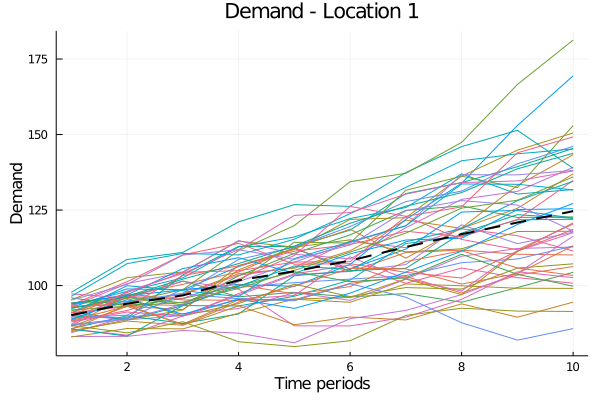

In [8]:
## Considering 50 scenarios for this study
nS = 50
D_sto, Ps = create_scenarios(ins, nS);

## Plotting the scenarios for a single locatiom
location = 1  # selected location for plotting

## Creating empty plot
plt = plot(
    xlabel = "Time periods",
    ylabel = "Demand",  
    title = "Demand - Location $(location)",
    legend = false, fmt = :png
)

## Including each demand series in the plot
for s in 1:nS                                 
    plot!(D_sto[s,location,:], legend = false)
end

## Plotting the expected demand 
plot!(sum(Ps[s]*D_sto[s,location,:] for s in 1:nS), 
    lw = 2,          # line weight
    ls = :dash,      # line stroke
    color = :black, 
    legend = false
)

plt

## Task 1.2

You are required to complete the function ```solve_stochastic()``` below. 


Just like in Task 1.1, you are required to complete this function by 
1. Adding the model variables
2. Adding the model objective
3. Adding the model constraints.

Notice that the object ```model``` has been already predefined and that the total number of scenarios ```nS``` as well as the probabilities ```Ps``` and demands ```d_sto``` for all scenarios are given as an arguments of the function.

In [9]:
# THIS CELL WILL BE AUTOGRADED
function solve_stochastic(ins::Instance, nS, Ps, D_sto; verbose=true)

    ## Renaming for making the implementation clearer    
    I = ins.I
    J = ins.J
    T = ins.T 
    C = ins.C
    H = ins.H
    M = ins.M
    Q = ins.Q
    F = ins.F
    
    S = 1:nS    # set of scenarios 
    
    model = Model(Cbc.Optimizer)      

    ## Variables
    @variable(model, x[i in I] >= 0)                            # Capacity per supplier (independent on the scenarios realisation)
    @variable(model, p[s in S, i in I, t in T] >= 0)            # Units produced per supplier i, per period t, and scenario sc
    @variable(model, k[s in S, i in I, t in T] >= 0)            # Units stored in each supplier i, period t, and scenario sc
    @variable(model, e[s in S, i in I, j in J, t in T] >= 0)    # Units transported from supplier i to demand point j at period t and scenario sc
    @variable(model, u[s in S, j in J, t in T] >= 0)            # Unfulfilled demand per demand point j, period t, and scenario sc

    ## Objective: Minimize the total phase 1 + phase 2 costs over all scenarios
    @objective(model, Min,
      sum(C[i] * x[i] for i in I) +
      sum(Ps[s] * H[i] * k[s,i,t] for s in S, t in T, i in I) + 
      sum(Ps[s] * M[i] * p[s,i,t] for s in S, t in T, i in I) +
      sum(Ps[s] * F[i,j] * e[s,i,j,t] for s in S, t in T, i in I, j in J) + 
      sum(Ps[s] * Q[j] * u[s,j,t] for s in S, t in T, j in J) 
    )

    ## Constraints
    ## Capacity limit for each supplier i in each period t
    @constraint(model, Cap[s in S, i in I, t in T], p[s,i,t] <= x[i])

    ## Supply balance constraint
    # (T=1): First period do not count with previous stocks
    @constraint(model, SupBal1[s in S, i in I, t in [1]], p[s,i,t] == sum(e[s,i,j,t] for j in J) + k[s,i,t]) 
    # (T>1): All periods but the first are balanced with the storage levels decided in the previous periods
    @constraint(model, SupBal2[s in S, i in I, t in T[T.>1]], p[s,i,t] + k[s,i,t-1] == sum(e[s,i,j,t] for j in J) + k[s,i,t])

    ## Demand balance constraint (u[j,s] is unfulfilled demand of client j in scenario s)
    @constraint(model, DemBal[s in S, j in J, t in T], sum(e[s,i,j,t] for i in I) == D_sto[s,j,t] - u[s,j,t])

    if verbose 
        println("Solving stochastic model with $(nS) scenarios...")    
    else
        set_silent(model)                      # Hides solver log
    end
    optimize!(model)                           # Solve the problem

    status = termination_status(model)         # Solution status
    
    if verbose 
        println(status)                        # Print status
    end
    
    return (x,p,k,e,u)
end;    

Once the implementation is completed, we can run the stocahstic model and extract the optimal solution.

In [10]:
## Solve the stochastic model
(x_sto, p_sto, k_sto, e_sto, u_sto) = solve_stochastic(ins, nS, Ps, D_sto, verbose = false)

xsol_sto = value.(x_sto)                          # Get optimal x values (reserved capacities)
xsol_sto = round.(xsol_sto.data, digits = 2)      # Round to 2 decimals 
fval_sto = dot(C, xsol_sto)                       # Optimal cost of reserved capacities

## Print optimal solution
println("Optimal solution:\n")
for i = 1:length(xsol_sto)
    if xsol_sto[i] > 0.0
        println("x[$(i)] = $(xsol_sto[i])")
    end
end

## Print optimal cost of reserved capacities
println("\nOptimal cost of reserved capacities: ", fval_sto)

Optimal solution:

x[1] = 28.25
x[6] = 954.73
x[13] = 1925.11
x[14] = 532.36
x[16] = 61.12
x[17] = 29.57
x[18] = 194.84
x[21] = 849.61

Optimal cost of reserved capacities: 281280.00999999995


Notice how the solutions compare in terms of total capacity invested and number of nodes selected as suppliers. Are the capacity centres more centralised or more disperse? Can you think of a reason why (the latter is not relevant for the task, but an interesting thought exercise)? 

We also provide a computational comparison of the two models using ```BenchmarkTools.jl``` why allow for profiling code and checking how much time and memory our code takes. That is by the way one of the main reason why we wrapped our model generation and solving into a function. 

How do the two models compare in terms of computational requirements? 

In [11]:
# Comparing the solution times between the two models. Notice this might take a while since BenchmarkTools 
#rerun the model several times to obtain average running times.

det_performance = @benchmark solve_deterministic(ins, verbose = false);
sto_performance = @benchmark solve_stochastic(ins, nS, Ps, D_sto, verbose = false);

In [12]:
# Deterministic performance
det_performance

BenchmarkTools.Trial: 
  memory estimate:  14.72 MiB
  allocs estimate:  190173
  --------------
  minimum time:     42.799 ms (0.00% GC)
  median time:      49.639 ms (0.00% GC)
  mean time:        51.300 ms (4.12% GC)
  maximum time:     83.377 ms (30.19% GC)
  --------------
  samples:          98
  evals/sample:     1

In [13]:
# Stochastic performance
sto_performance

BenchmarkTools.Trial: 
  memory estimate:  810.47 MiB
  allocs estimate:  10482202
  --------------
  minimum time:     16.196 s (1.60% GC)
  median time:      16.196 s (1.60% GC)
  mean time:        16.196 s (1.60% GC)
  maximum time:     16.196 s (1.60% GC)
  --------------
  samples:          1
  evals/sample:     1